In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
import cv2 as cv

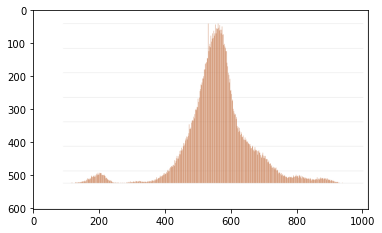

In [4]:
base = cv.imread('base.png')
plt.imshow(base)

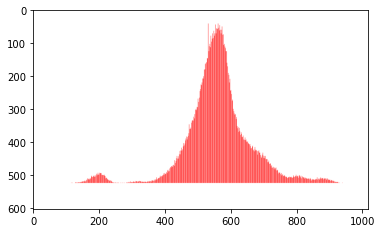

In [5]:
ret, thresh = cv.threshold(base,120,255,cv.THRESH_BINARY)

plt.imshow(thresh)

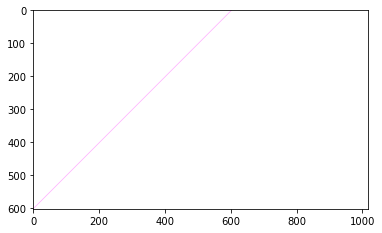

In [4]:
#get idea of how to move across image
ret, thresh = cv.threshold(base,120,255,cv.THRESH_BINARY)
thresh[:,:,0]=255
thresh[:,:,1]=255
thresh[:,:,2]=255
for i in range(604):
    thresh[603-i,i,1]=0
plt.imshow(thresh)

In [ ]:
#go along x-axis to find start pixel (the 2nd and third layers have all the data 255 is white)
#start at bottom left and go across each row until you find a 0
#mark the the first point enter new nested loop
#if we are on a bar -> go up vertically until the point equals zero -> save point into curve array
#(604,1018,3)
#Start y -  524
#Start x -  116

In [5]:
def find_top(vert):
    for i in range(len(vert)):
        if (vert[i]==0)&(vert[i-1]==255):
            return i
        

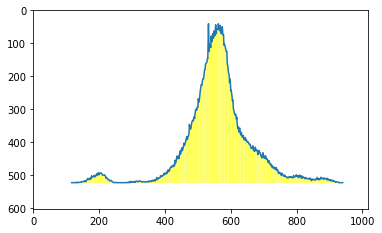

In [6]:
ret, thresh = cv.threshold(base,120,255,cv.THRESH_BINARY)
thresh[:,:,0]=255
thresh[:,:,1]=255
a=0
#find x-axis
for i in range(604):
    if a ==0:
        for j in range(1018):
            if thresh[603-i,j,2]==0:
                starty = 603-i
                a=1
                break
    else:
        break
#get base points
a=0
for i in range(1018):
    if thresh[starty,i,2]==0:
        if a == 0:
            bottom = np.array(i)
            a=1
        else:
            bottom = np.append(bottom,i)
#get top points
a=0
for i in bottom:
    if a==0:
        top = np.array(find_top(thresh[:,i,2]))
        a=1
    else:
        top = np.append(top,find_top(thresh[:,i,2]))
plt.plot(bottom,top)
plt.imshow(thresh)

(0.0, 3250.0)

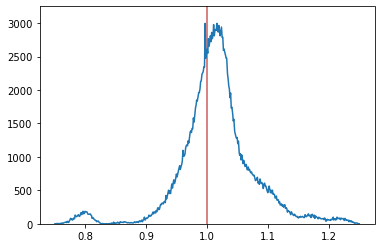

In [7]:
#scale
#max count value/max_arr_value*arr
top_scaled = -1*(3250/np.max(top)*top-3250) #it was upside down bc of the way images are indexed
#plt.plot(np.arange(len(top)),top_scaled)
#between every two points add 64 linearly spaced points
a=0

for i in range(len(top_scaled)-1):
    if a==0:
        new = np.array(np.linspace(top_scaled[i],top_scaled[i+1],num=64))
        a=1
    else:
        new = np.append(new,np.linspace(top_scaled[i],top_scaled[i+1],num=64))
newx = np.linspace(0.75,1.25,num=len(new))
plt.plot(newx,new)
plt.vlines(1,0,3250,colors='indianred')
plt.ylim((0,3250))


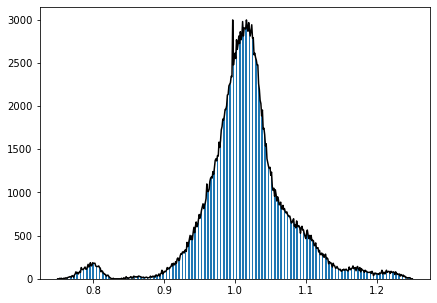

In [113]:
#Recreate initial Plot
w = 0.5/len(top_scaled)*0.5
x = np.linspace(0.75,1.25,num=len(top_scaled))
height = top_scaled
plt.figure(figsize=(7,5))
plt.bar(x,height, width=w)
plt.plot(x,height,'black')
plt.savefig('recreated.png')

In [55]:
#calculate mean
s = 0
for i in range(len(new)):
    s = s +new[i]*newx[i]
mean = s/np.sum(new)
mean

1.0163153571031365

In [57]:
#calculate stdev
'''
S = SQRT((SUMi(fi*xi**2)-n(mean))/(n-1))
fi = frequency at i
xi = rcf at i
n = sum of frequencies, # of samples
fx2 = SUMi(fi*xi**2)
'''
s = 0
fx2 = 0
n = np.sum(new)
for i in range(len(new)):
    s = s +new[i]*newx[i]
    fx2 = fx2 + new[i]*newx[i]**2
mean = s/np.sum(new)
stdev = ((fx2-n*mean)/(n-1))**(0.5)
stdev

0.14271335394991724

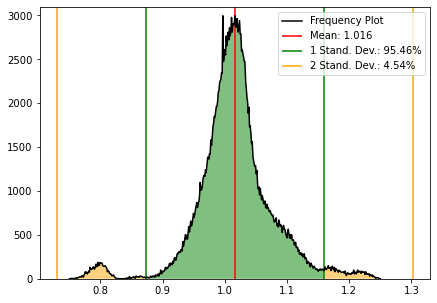

In [112]:
#Create stats plot
m = max(new)+100
fig, ax = plt.subplots(figsize=(7,5))
#curve
plt.plot(newx,new,color='black',label='Frequency Plot')
#mean
plt.vlines(mean,0,m,colors='red',label='Mean: '+str(round(mean,3)))
#standard deviation lines
#constants
xl = mean-stdev
xr = mean+stdev
xl2 = mean-2*stdev
xr2 = mean+2*stdev
plt.vlines(xl,0,m,colors='green', label = '1 Stand. Dev.: 95.46%')
plt.vlines(xr,0,m,colors='green')
plt.vlines(xl2,0,m,colors='orange', label = '2 Stand. Dev.: 4.54%')
plt.vlines(xr2,0,m,colors='orange')
#shading
ax.fill_between(newx,0,y2=new,where=(xl<newx)&(newx<xr),
             facecolors='green',alpha=0.5)
ax.fill_between(newx,0,y2=new,where=((xl2<newx)&(newx<xl))|((xr<newx)&(newx<xr2)),
               facecolors='orange',alpha=0.5)
#legend
plt.legend()
#limits
plt.ylim([0,m])
plt.savefig('statsplot.png')

In [101]:
#Characterize distribution
def find(newx,goal):
    for i in range(len(newx)):
        if newx[i]>goal:
            return i
#normalize distrubution
norm = new/np.sum(new)
#1 std
rcfl = find(newx,mean-stdev)
rcfr = find(newx,mean+stdev)
#2 std
rcfl2 = find(newx,mean-2*stdev)
rcfr2 = find(newx,mean+2*stdev)

#percent within 1 std
per1 = np.sum(norm[rcfl:rcfr])
per2 = np.sum(norm[rcfl2:rcfl])+np.sum(norm[rcfr:rcfr2])
print('Percent in 1 STD: ',round(per1*100,2),'%')
print('Percent in 2 STD: ',round(per2*100,2),'%')

Percent in 1 STD:  95.46 %
Percent in 2 STD:  4.54 %


In [38]:
def find_std(arr, std, start=14911, num=1, steps = 1):
    #sum from 5 points to the left
    suml = np.sum(arr[(start-steps*5):start])
    #sum from 5 to the right
    sumr = np.sum(arr[start:(start+steps*5)])
    #if total < per, call again
    if (suml+sumr)<std*num:
        steps = steps + 1
        return prob_area(arr,std,num=num,steps=steps)
    else:
        return steps

In [40]:
find_std(new,stdev)

1

In [106]:
def prob_area(arr, per, start = 14911, steps = 1):
    #sum from 5 points to the left
    suml = np.sum(arr[(start-steps*5):start])
    #sum from 5 to the right
    sumr = np.sum(arr[start:(start+steps*5)])
    #if total < per, call again
    if (suml+sumr)<per:
        steps = steps + 1
        return prob_area(arr,per,steps=steps)
    else:
        return steps
    #if it is >= per, return per and range

In [107]:
#find where plot is at RCF=1
for i in range(len(newx)):
    if newx[i]<1:
        if newx[i+1]>1:
            rcf_cent = i



In [111]:
def per_plots(new,newx,per):
    #Probability
    #Need the are of the curve to equal 1
    norm=new/np.sum(new)
    #Go out from 1 and take derivatives -> write recursive function with variable %
    var = prob_area(norm,per)
    #put vlines in range
    r = (1.25-0.75)/len(norm)
    xl = 1-var*r*5
    xr = 1+var*r*5
    #plot
    fig, ax = plt.subplots(figsize=(7,5))
    ax.fill_between(newx,0,y2=norm, where =(xl<newx)&(newx<xr),facecolor='r',alpha=0.5)
    plt.plot(newx,norm, color='black')
    plt.vlines(xr,0,np.max(norm),colors='r',)
    plt.vlines(xl,0,np.max(norm), colors='r')
    plt.title('RCF Range for '+str(per*100)+'% of Values: ['+str(round(xl,3))+', '+str(round(xr,3))+']')
    file = 'Plot for '+str(per*100)+' percent.jpg'
    plt.ylabel('% of Total')
    plt.xlabel('RCF')
    plt.savefig(file)
    plt.close()

In [109]:
#convert above cell into function and generate ranges for 50%, 75%, 90%
for p in [0.66,0.9,0.98]:
    per_plots(new,newx,p)